In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import warnings
warnings.filterwarnings('ignore')

In [3]:
from zipfile import ZipFile

In [ ]:
!unzip "/content/drive/My Drive/MachineHack/cvhackathon/Data.zip" -d "cv_dataset"

In [5]:
# Get the train dataframe 
dataset_train=pd.read_csv('cv_dataset/Data/Train.csv')

# Get the test dataframe (for loop is written to get the names of images in order to get the test dataframe) #optional step
import glob
test_img_names = []
for img in glob.glob("cv_dataset/Data/Test/*.jpg"):
    test_img_names.append(img.split('cv_dataset/Data/Test/')[1])

# cobverting from list to dataframe
dataset_test = pd.DataFrame(test_img_names,index=None,columns=['File_Name'])

# get the submission file 
submission_file = pd.read_csv('cv_dataset/Data/Sample_Submission.csv')

In [6]:
print(dataset_train.shape)
print(dataset_test.shape)
print(submission_file.shape)

(9471, 2)
(4059, 1)
(4059, 2)


In [7]:
train_imagesdf=[]
for file1 in dataset_train["File_Name"].values:
      image = cv2.imread("cv_dataset/Data/Train/Images"+file1)
      train_imagesdf.append(image)

test_imagesdf=[]
for file1 in dataset_test["File_Name"].values:
      image = cv2.imread("cv_dataset/Data/Test"+file1)
      test_imagesdf.append(image)

In [8]:
train_images = train_imagesdf
test_images= test_imagesdf
image_directory_train='cv_dataset/Data/Train'
image_directory_test='cv_dataset/Data/'

In [9]:
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from fastai.callbacks.hooks import *

## Transformations

In [10]:
tfms = get_transforms(do_flip=True,flip_vert=False ,max_rotate=10.0, max_zoom=1.22, max_lighting=0.22, max_warp=0.0, p_affine=0.75,
                      p_lighting=0.75)

In [11]:
train_img = ImageList.from_df(dataset_train, path=image_directory_train, folder='Images')

In [12]:
test_img = ImageList.from_df(dataset_test, path=image_directory_test, folder='Test')

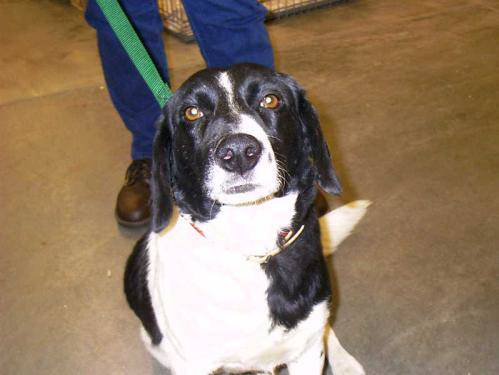

In [13]:
test_img[0]

In [14]:
np.random.seed(145)
## create source of train image databunch
src = (train_img
       .split_by_rand_pct(0.2)
       .label_from_df()
       .add_test(test_img)
       )

In [15]:
data = (
        src.transform(tfms, size=299,padding_mode='reflection',resize_method=ResizeMethod.SQUISH)
        .databunch(path='.', bs=32, device= torch.device('cuda:0'))
        .normalize(imagenet_stats)
        )

In [16]:
print(data.classes)

[0, 1]


In [17]:
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[FBeta(beta=1, average='macro'), accuracy],callback_fns=ShowGraph)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,f_beta,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-04
Min loss divided by 10: 1.91E-03


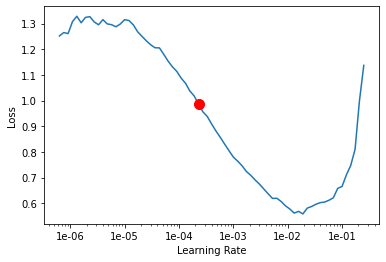

In [18]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

## Training


epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.140590,0.059646,0.983622,0.983633,01:47
1,0.060878,0.033983,0.991014,0.991024,01:46
2,0.044570,0.026003,0.992599,0.992608,01:47
3,0.037766,0.021948,0.991014,0.991024,01:43


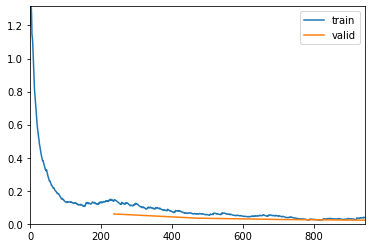

In [19]:
lr = 1e-03
learn.fit_one_cycle(4, slice(lr), wd=0.2)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.038946,0.019945,0.993130,0.993136,01:43


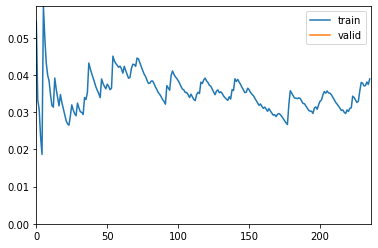

In [20]:
learn.fit_one_cycle(1, slice(lr/2), wd=0.2)

## Export

In [21]:
learn.export(file = Path("/content/drive/My Drive/MachineHack/cvhackathon/export.pkl"))

In [22]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

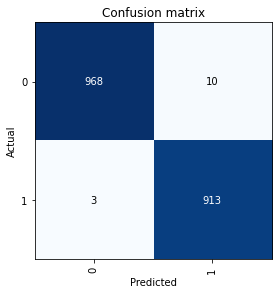

In [23]:
interp.plot_confusion_matrix()

In [24]:
interp.most_confused()

[(0, 1, 10), (1, 0, 3)]

## Predictions

In [25]:
preds,_ = learn.TTA(ds_type=DatasetType.Test) # 
# preds,_ = learn.get_preds(ds_type = DatasetType.Test)
labelled_preds = [np.argmax(preds[i]) for i in range(len(preds))]
labelled_preds = np.array(labelled_preds)

In [26]:
preddf = pd.DataFrame(np.array(preds))

In [28]:
df = pd.DataFrame({'File_Name':dataset_test['File_Name'], 'Category':labelled_preds})
df["Category"] = df["Category"].astype(int)
df["File_Name"] = df["File_Name"].astype(str)
df.to_excel('submission5.xlsx', index=False)

## Extra work

epoch,train_loss,valid_loss,accuracy,time
0,0.469727,0.050929,0.987328,03:19
1,0.372548,0.049475,0.987328,03:15
2,0.361654,0.070130,0.984160,03:16
3,0.326688,0.036527,0.989440,03:16
4,0.296305,0.045344,0.990496,03:18
5,0.288845,0.044262,0.991552,03:23


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 6.31E-08


epoch,train_loss,valid_loss,accuracy,time
0,0.278081,0.046826,0.991552,03:07
1,0.276866,0.047459,0.993664,03:07
2,0.276156,0.039877,0.993664,03:03
3,0.284429,0.047942,0.992608,03:06
4,0.278528,0.044868,0.994720,03:08
5,0.269192,0.041909,0.994720,03:04


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.498425,0.088771,0.973601,03:07
1,0.388737,0.085496,0.974657,03:01
2,0.382649,0.141474,0.956705,03:01
3,0.348096,0.122232,0.964097,03:01
4,0.327595,0.089329,0.976769,03:01
5,0.297616,0.080096,0.977825,03:01


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 5.75E-05


epoch,train_loss,valid_loss,accuracy,time
0,0.303654,0.078523,0.974657,02:36
1,0.304193,0.078419,0.975713,02:37
2,0.294012,0.077838,0.974657,02:37
3,0.289467,0.078624,0.976769,02:39
4,0.286249,0.077473,0.977825,02:38
5,0.277779,0.077892,0.977825,02:38


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.505824,0.246824,0.980993,04:50
1,0.458901,0.164840,0.950370,04:48
2,0.550520,4.977221,0.928194,04:47
3,0.490673,0.156639,0.942978,04:48
4,0.472019,0.173804,0.946146,04:48
5,0.452711,0.144194,0.954593,04:47


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 6.31E-08


epoch,train_loss,valid_loss,accuracy,time
0,0.409167,0.144436,0.952482,03:34
1,0.431275,0.195575,0.953537,03:34
2,0.432738,0.154445,0.952482,03:33
3,0.417538,0.137090,0.955649,03:35
4,0.388164,0.179793,0.954593,03:34
5,0.402251,0.155098,0.951426,03:35


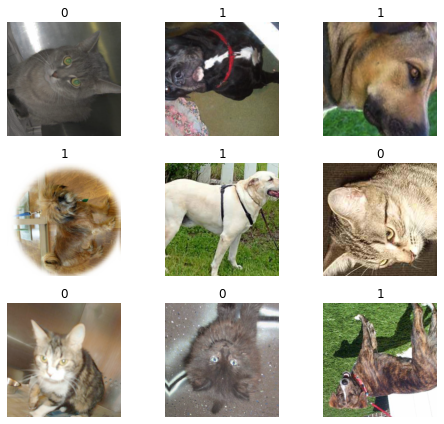

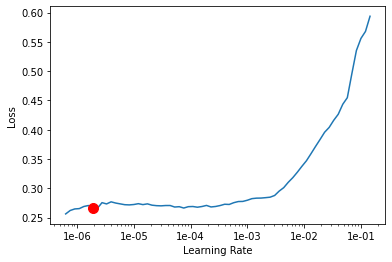

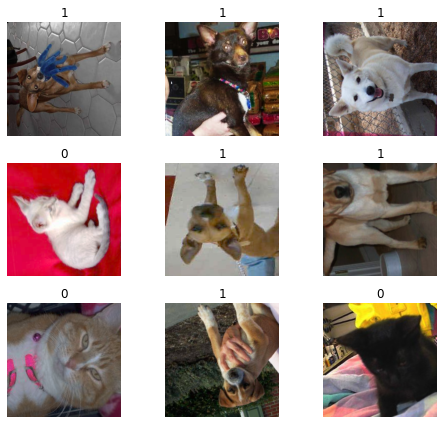

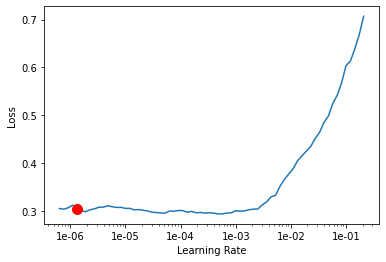

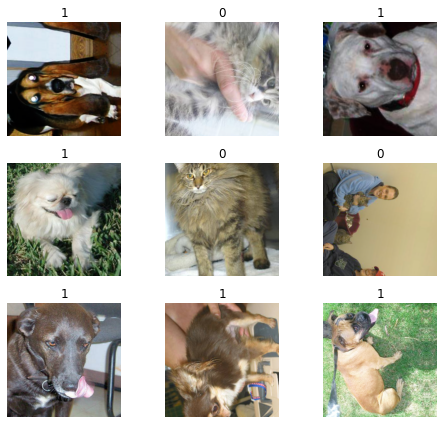

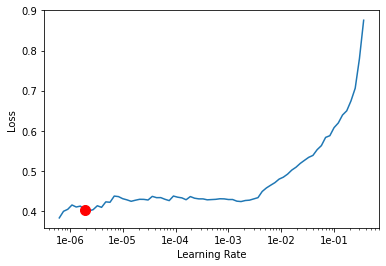

In [ ]:
j=1
results={}

for model in [models.densenet121, models.resnet50, models.resnet101]:
  #Image Augumentation on train and test
  test_img = ImageList.from_df(dataset_test, path=image_directory_test, folder='Test');
  trfm = get_transforms(do_flip=True, flip_vert=True, max_zoom=1.2, max_rotate=20.0, max_lighting=0.4);#, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)
  train_img = (ImageList.from_df(dataset_train, path=image_directory_train, folder='Images')
          .split_by_rand_pct(0.1)
          .label_from_df()
          .add_test(test_img)
          .transform(trfm, size=224)
          .databunch(path='.', bs=64, device= torch.device('cuda:0'))
          .normalize(imagenet_stats)
        );

  train_img.show_batch(rows=3, figsize=(7,6));
  #mixup is used for additional Augumentation
  learn = cnn_learner(train_img, model, metrics=[ accuracy]).mixup();
  #training the model by unfreezing all the layers 
  # learn.unfreeze();
  # #fast.ai offers differential learning rate
  # #starting layers will concentrate on sides and corners of the image as the network goes deep more learning is required for concentarting important features of the image
  # learn.fit_one_cycle(6, max_lr =[8e-6, 8e-4, 8e-3] );#slice(8e-6, 8e-3)
  # #Finding learning rate based on the training
  # learn.lr_find();
  # learn.recorder.plot(suggestion=True);

  #Training the model by freezing all the previously trained layers
  learn.freeze();
  learn.fit_one_cycle(6, max_lr =slice(1e-6,1e-4));#slice(8e-6, 8e-3)
  #Test Time Augumentation(TTA) provides probabilities of output classes based on different augumentations applied on test image
  preds,pred1 = learn.TTA(ds_type=DatasetType.Test);
  pred_class = np.argmax(preds.numpy(),axis=1);
  results[j]=pred_class;
  j+=1;

In [ ]:
def genelabel(model, string):
    id_list=list(dataset_test.File_Name)
    label=[]
    for iname in id_list:
        img=open_image(image_directory_test+"/Test/"+iname)
        label.append(model.predict(img)[0])
        if (len(label)%350 == 0):
            print(f'{len(label)} images done!')
    return label

In [ ]:
tfms = get_transforms(do_flip = True, max_lighting = 0.2, max_zoom= 1.1, max_warp = 0.15, max_rotate = 45)
data = ImageDataBunch.from_csv('cv_dataset/Data', folder= 'Train/Images', 
                              valid_pct = 0.0,
                              csv_labels = 'Train.csv',
                              ds_tfms = tfms, 
                              fn_col = 'File_Name',
                              #test = 'train_SOaYf6m/images', 
                              label_col = 'Category',
                              bs = 16,
                              size = 300).normalize(imagenet_stats)

In [ ]:
fbeta = FBeta(average='weighted', beta = 1)
learn = cnn_learner(data, models.resnet101, metrics=[accuracy, fbeta])
learn.fit(epochs = 30, lr = 1.5e-4)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [ ]:
results

{1: array([0, 0, 0, 1, ..., 0, 1, 0, 0])}

In [ ]:
# models.vgg16_bn
d = pd.DataFrame()
d = pd.concat([d,pd.DataFrame(results[1])],axis=1)
d.columns=['1']

# re = d.mode(axis=1)[0]

In [ ]:
d.columns=['0']

In [ ]:
# # models.
# densenet101 = pd.DataFrame()
# densenet101 = pd.concat([densenet101,pd.DataFrame(results[1])],axis=1)
# densenet101.columns=['1','2','3']

In [ ]:
final = pd.DataFrame()
for i in range(1,4):
    final = pd.concat([final,pd.DataFrame(results[i])],axis=1)

final = pd.concat([final,d],axis=1)
final.columns=['0','1','2','3']
final = final.mode(axis=1)[0]

In [ ]:
final.shape

(4059,)

In [ ]:
final.head()

0    0.0
1    0.0
2    0.0
3    1.0
4    1.0
Name: 0, dtype: float64

In [ ]:
dataset_submission=submission_file
dataset_submission['Category']=d
dataset_submission.to_csv('/content/drive/My Drive/MachineHack/cvhackathon/dense101_lr.csv', index=False)